/var/folders/tw/j68gkt955z57h83crjdjjrg80000gr/T/ipykernel_60079/1851732833.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels, cmap=matplotlib.cm.get_cmap('RdYlBu_r'))


(-0.4999999881670285, 0.49998642688856054)

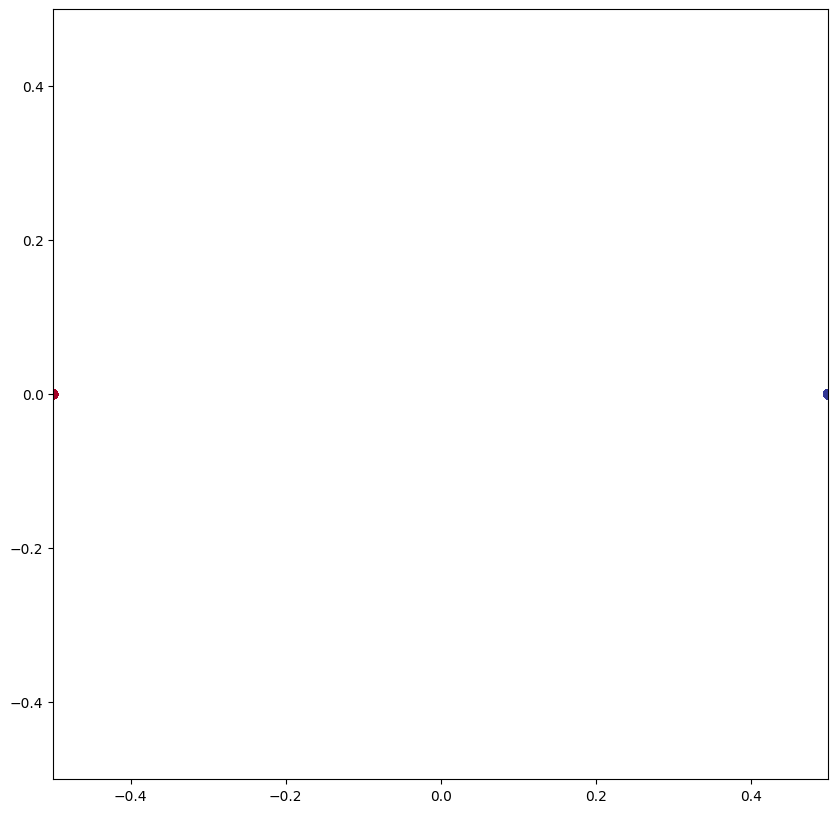

In [1]:
import os, sys, numpy, torch, matplotlib.pyplot, matplotlib.cm

sys.path += [os.path.abspath(os.path.join('..')), os.path.abspath(os.path.join('../..'))]  # Allow repository modules to be imported

from settings.noisy_xor import get_dataloader
from utils.optimization import initialize

experiment = {
    'seed': 1234,
    'dataset': 'linear',
    'input_dimension': 2, 
    'sample_size': 5000,  
    'batch_size': 5000, 
    'within_cluster_variance': 10e-10,
    'clusters_per_class': 1, 
    'epochs': 1000,
    'learning_rate': 0.1,
    'initial_hidden_units': 1,
    'initialization_variance': 0.00001,
    'bias': True,
    'balanced_initialization': True,
    'normalize_inputs': True,
    'scale_inputs': 0.5
}

device, generator = initialize(experiment['seed'])
train_data, rotation_matrix = get_dataloader(**experiment, generator=generator)
test_data = get_dataloader(**experiment, rotation_matrix=rotation_matrix, generator=generator)
inputs = []; labels = []
for batch_inputs, batch_labels in train_data: inputs.append(batch_inputs); labels.append(batch_labels)
inputs, labels = torch.concatenate(inputs), torch.concatenate(labels)

fig, ax = matplotlib.pyplot.subplots(figsize=(10, 10))
inputs_ = numpy.matmul(inputs.detach().cpu().numpy(), rotation_matrix.transpose())
ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels, cmap=matplotlib.cm.get_cmap('RdYlBu_r'))
ax.set_xlim(inputs_[:, 0].min(), inputs_[:, 0].max())
ax.set_ylim(inputs_[:, 0].min(), inputs_[:, 0].max())

In [1]:
import ipycanvas

training_canvas, weights_and_biases_canvas, gradients_norms_canvas, input_domain_canvas = ipycanvas.Canvas(), ipycanvas.Canvas(), ipycanvas.Canvas(), ipycanvas.Canvas()
training_canvas.width, training_canvas.height = 1200, 600
weights_and_biases_canvas.width = 800; weights_and_biases_canvas.height = 800
gradients_norms_canvas.width = 1200; gradients_norms_canvas.height = 600
input_domain_canvas.width = input_domain_canvas.height = 800
training_canvas.font = weights_and_biases_canvas.font = gradients_norms_canvas.font = input_domain_canvas.font = "30px arial"
args = ('Results will appear as processed', training_canvas.width / 4, training_canvas.height / 3)
training_canvas.fill_text(*args); weights_and_biases_canvas.fill_text(*args); gradients_norms_canvas.fill_text(*args); input_domain_canvas.fill_text(*args)

In [2]:
training_canvas

Canvas(height=600, width=1200)

In [3]:
weights_and_biases_canvas

Canvas(height=800, width=800)

In [4]:
gradients_norms_canvas

Canvas(height=600, width=1200)

In [5]:
input_domain_canvas

Canvas(height=800, width=800)

In [7]:
from functools import partial
from plots import (plot_train_loss_and_accuracy, plot_weights_norm_and_biases, 
                   plot_weights_and_biases_gradient_norms, plot_samples_activation_hyperplanes)
from utils.models import FullyConnectedNeuralNetwork
from experiment import execute_experiment

plot_train_loss_and_accuracy = partial(plot_train_loss_and_accuracy, canvas=training_canvas)
plot_weights_norm_and_biases = partial(plot_weights_norm_and_biases, canvas=weights_and_biases_canvas)
plot_weights_and_biases_gradient_norms = partial(plot_weights_and_biases_gradient_norms, canvas=gradients_norms_canvas)
plot_samples_activation_hyperplanes = partial(plot_samples_activation_hyperplanes, canvas=input_domain_canvas, 
                                              rotation_matrix=rotation_matrix, dataloader=train_data)

def model_summary(model, model_metrics, epoch, *args, **kwargs):
    for layer_index, layer in enumerate(model.layers):
        layer_metrics = {'epoch': epoch, 'layer': layer_index, 'hidden_units': layer.weight.shape[0],
                         'neurons_weights_norm': layer.weight.norm(dim=1).detach().cpu().tolist()}
        if experiment['bias']: layer_metrics.update({'biases': layer.bias.detach().cpu().tolist()})
        model_metrics.append(layer_metrics)
        
    model_metrics.append({'epoch': epoch, 'layer': len(model.layers), 'hidden_units': model.output_layer.weight.shape[1],
                          'neurons_weights_norm': model.output_layer.weight.abs().squeeze(dim=0).detach().cpu().tolist()})

execute_experiment(
    **experiment,
    experiment_name_parameters=['seed'],
    train_data=train_data, 
    test_data=test_data, 
    model_class=FullyConnectedNeuralNetwork,
    growing_epochs_interval=1,
    saving_epochs_interval=experiment['epochs'],
    callbacks_epochs_interval=1,
    callbacks=[model_summary, plot_train_loss_and_accuracy, plot_weights_norm_and_biases, 
               plot_weights_and_biases_gradient_norms, plot_samples_activation_hyperplanes],
    override=True
)

/Users/LePalma/Documents/git/nns_growth/notebooks/utils/models.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.output_layer.weight.copy_(self.output_layer.weight.sign() * torch.tensor(self.layers[0].weight.norm(dim=1)))
